In [231]:
import os
import io
import operator
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import LeaveOneOut, KFold
import matplotlib.pyplot as plt
%matplotlib inline



CHARGED="charged/"
NON_CHARGED="non_charged/"

In [232]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

len_file={}
for filename in os.listdir(CHARGED):
    len_file[filename]=file_len(CHARGED+filename)

In [233]:
def create_df(fname):
    l=[]
    fname=fname
    file=open(fname,'r')
    file=file.readlines()
    for e in file:
        e=e.replace(' ','')
        e=e[:-1].split(',')
        ideology=float(e[0])
        count=int(e[1])
        freq1=float(e[2])
        freq2=float(e[3])
        duration=float(e[4])
        F11=float(e[5])
        F12=float(e[6])
        F13=float(e[7])
        F21=float(e[8])
        F22=float(e[9])
        F23=float(e[10])
        l.append([ideology,count,freq1,freq2,duration,F11,F12,F13,F21,F22,F23])
    return l
        
        

In [249]:
sorted_len_file=sorted(len_file.items(), key=lambda x: -x[1])

In [278]:
l_df=create_df(CHARGED+sorted_len_file[4][0])
col=['Ideology','Count','Freq1','Freq2','Duration','F11','F12','F13','F21','F22','F23']
df=pd.DataFrame(l_df)
df.columns=col
y=df['Ideology']
x=df.drop('Ideology',axis=1)
x['constant']=np.ones(len(x))

In [279]:
loo=LeaveOneOut()

In [280]:
lambdas=np.arange(1e-3,1.5e-2,1e-3)
scores=[]
kf=KFold(n_splits=20)
for train_index, test_index in kf.split(x):
    history=[]
    X_train, X_test = x.T[train_index].T, x.T[test_index].T
    y_train, y_test = y.T[train_index].T, y.T[test_index].T
    for i in range(len(lambdas)):
        l=lambdas[i]
        lr=Ridge(alpha=l,normalize=True)
        lr.fit(X_train,y_train)
        score=lr.score(X_test,y_test)
        history.append(score)
    scores.append(history)

s_ridge=np.zeros(len(lambdas))
for e in scores:
    for i in range(len(e)):
        s_ridge[i]+=e[i]/len(scores)
        
scores=[]
for train_index, test_index in kf.split(x):
    history=[]
    X_train, X_test = x.T[train_index].T, x.T[test_index].T
    y_train, y_test = y.T[train_index].T, y.T[test_index].T
    for i in range(len(lambdas)):
        l=lambdas[i]
        lr=Lasso(alpha=l,normalize=True)
        lr.fit(X_train,y_train)
        score=lr.score(X_test,y_test)
        history.append(score)
    scores.append(history)

s_lasso=np.zeros(len(lambdas))
for e in scores:
    for i in range(len(e)):
        s_lasso[i]+=e[i]/len(scores)

scores=[]
for train_index, test_index in kf.split(x):
    history=[]
    X_train, X_test = x.T[train_index].T, x.T[test_index].T
    y_train, y_test = y.T[train_index].T, y.T[test_index].T
    for i in range(len(lambdas)):
        l=lambdas[i]
        lr=ElasticNet(alpha=l,normalize=True)
        lr.fit(X_train,y_train)
        score=lr.score(X_test,y_test)
        history.append(score)
    scores.append(history)

s_elastic=np.zeros(len(lambdas))
for e in scores:
    for i in range(len(e)):
        s_elastic[i]+=e[i]/len(scores)




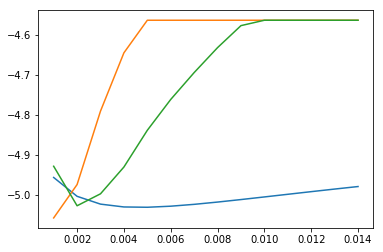

In [281]:
plt.plot(lambdas,s_ridge)
plt.plot(lambdas,s_lasso)
plt.plot(lambdas,s_elastic)